In [1]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product

%matplotlib inline

In [2]:
# Use the matplotlib plotting styles
CURR_PATH = pathlib.Path().parent
MPLSTYLE = CURR_PATH.joinpath("plotstyle.mplstyle")
plt.style.use(MPLSTYLE)

In [3]:
M_PROTON = 0.938272
M_NEUTRON = 0.93957
M_N = ((M_PROTON + M_NEUTRON) / 2)**2

In [55]:
EXPERIMENT = "FLArE100"

In [56]:
def read_txt_pd(exp: str = "FASERv2", otype: str = "inclusive", charge: str = "nu") -> pd.DataFrame:
    
    path = f"clipped_nan_binned_sysevents_{exp}_{otype}_{charge}.txt"
    fpath = CURR_PATH.joinpath(f"NNPDF_commondata/stat_syst_uncertainties/{path}")
    
    colnames = [
        "x_lower", 
        "x_upper", 
        "x_avg", 
        "Q2_lower", 
        "Q2_upper", 
        "Q2_avg", 
        "E_nu_lower", 
        "E_nu_upper", 
        "E_nu_avg", 
        "d^sigma/dxdQ2", 
        "N_events", 
        "N_events_errs", 
        "N_sys_errs", 
        "Percent_error_theta", 
        "Percent_error_Elepton", 
        "Percent_error_Ehadron", 
        "MC_Samples",
    ]
    
    return pd.read_csv(fpath, skiprows=2, delim_whitespace=True, names=colnames)

In [57]:
def read_proper_cv(exp: str = "FASERv2", otype: str = "inclusive", charge: str = "nu") -> pd.DataFrame:
    path = f"diffxsec-{exp}_{otype}_{charge}-a1_PDF4LHC21_mc_iso.txt"
    fpath = CURR_PATH.joinpath(f"NNPDF_commondata/pineappl_tables/{path}")

    colnames = ["x", "y", "Q2", "nu", "nub"]

    return pd.read_csv(fpath, skiprows=1, delim_whitespace=True, names=colnames)

In [58]:
def map_q2values(q2_values):
    sort_q2s = np.sort(q2_values.values).astype(int)
    r1, r2 = np.array_split(sort_q2s, 2)
    # r1, r2, r3 = np.array_split(sort_q2s, 3)
    
    def value_mmapping(q2_value):     
        if q2_value <= r1[-1]:
            return r"$[" + f"{r1[0]},~{r1[-1]}" + "]~\mathrm{GeV}^2$"
        elif (r2[0] <= q2_value) and (q2_value <= r2[-1]):
            return r"$[" + f"{r2[0]},~{r2[-1]}" + "]~\mathrm{GeV}^2$"
        # else:
        #     return r"$[" + f"{r3[0]},~{r3[-1]}" + "]~\mathrm{GeV}^2$"

    return value_mmapping

In [59]:
def combine_tables(q2cut: float=3.5, w2cut: float=12.5) -> pd.DataFrame:
    otypes = ["inclusive", "charm"]
    charges = ["nu", "nub"]
    map_charges = {"nu": r"$\rm{neutrinos}~(\nu)$", "nub": r"$\rm{antineutrinos}~(\bar{\nu})$"}
    map_otypes = {
        "inclusive": r"$\nu / \bar{\nu} + N \to \ell^{\pm} + X$",
        "charm": r"$\nu / \bar{\nu} + N \to \ell^{\pm} + c / \bar{c} + X$",
    }
    
    combined_tables= []
    for otype, charge in product(otypes, charges):
        df = read_txt_pd(EXPERIMENT, otype, charge)
        df["otype"] = [map_otypes[otype]] * len(df)
        df["charge"] = [map_charges[charge]] * len(df)

        # Read the actual central values
        cv_df = read_proper_cv(EXPERIMENT, otype, charge)
        df["sigma_stat"] = 1.0 / df["N_events_errs"].to_numpy() * cv_df[charge].to_numpy()
        df["sigma_cv"] = cv_df[charge].to_numpy()
        df["sigma_frac"] = (df["sigma_stat"] * 100) / df["sigma_cv"] / 100
        
        combined_tables.append(df)
    
    df_combined = pd.concat(combined_tables, ignore_index=True)
    # Sort values by Q2s
    df_combined = df_combined.sort_values(by=['Q2_avg'])

    # Compute W2 values
    xxx = df_combined["x_avg"].astype(float, errors="raise")
    q2 = df_combined["Q2_avg"].astype(float, errors="raise")
    df_combined["W2_avg"] = q2 * (1.0 - xxx) / xxx + M_N

    # Apply kinematic cuts
    if q2cut is not None:
        df_combined = df_combined[df_combined["Q2_avg"] >= q2cut]
        
    if w2cut is not None:
        df_combined = df_combined[df_combined["W2_avg"] >= w2cut]
    
    # Map the values of Q2 to some string ranges
    df_combined["Q2_avg"] = df_combined["Q2_avg"].map(map_q2values(df_combined["Q2_avg"]))

    return df_combined

In [60]:
predictions = combine_tables(q2cut=3.5, w2cut=12.5)

In [61]:
predictions[["sigma_stat", "sigma_cv", "sigma_frac"]]

,sigma_stat,sigma_cv,sigma_frac
47,0.119509,1.263126,0.094614
48,0.063521,0.915511,0.069383
0,0.086128,1.494566,0.057627
1,0.048189,1.080037,0.044618
88,0.052399,0.529192,0.099017
...,...,...,...
42,0.000030,0.002603,0.011630
46,0.000013,0.000628,0.019970
35,0.000636,0.008178,0.077769
39,0.000217,0.004058,0.053571


In [66]:
rename_columns = {
    "Q2_avg": r"$Q^2~\rm{Ranges}$",
    "otype": r"$\rm{Processes}$",
    "charge": r"$\rm{Projectile}$",
}

def plot_percentage_error(data: pd.DataFrame):
    fig, axs = plt.subplots(
        nrows=2,
        ncols=2,
        sharey=False,
        figsize=(5 * 2, 3 * 2),
        # layout="constrained",
    )
    
    data = data.rename(columns=rename_columns)
    
    error_list = {
        "Percent_error_theta": (0, 0),
        "Percent_error_Elepton": (0, 1),
        "Percent_error_Ehadron": (1, 0),
        "sigma_frac": (1, 1)
    }

    for error, coord in error_list.items():
        ax = axs[coord[0], coord[-1]]
        legend = True if coord == (1, 1) else False
        
        sb = sns.scatterplot(
            data=data,
            x="x_avg",
            y=error,
            hue=r"$\rm{Processes}$",
            style=r"$\rm{Projectile}$",
            size=r"$Q^2~\rm{Ranges}$",
            ax=ax,
            legend=legend,
        )
    
        ax.set_xscale("log")

        if coord == (0, 0) or coord == (0, 1):
            sb.set(xlabel=None)
            ax.set_xticklabels([])
        else:
            ax.set_xlabel(r"$\langle x \rangle$")

        if error == "Percent_error_theta":
            ax.set_ylabel(r"$\rm{Fractional~Error~}(\theta)$")
            # ax.set_ylim(top=0.25)
        elif error == "Percent_error_Elepton":
            ax.set_ylabel(r"$\rm{Fractional~Error~}(E_{\ell})$")
            # ax.set_ylim(top=0.2)
        elif error == "Percent_error_Ehadron":
            ax.set_ylabel(r"$\rm{Fractional~Error~}(E_{h})$")
            # ax.set_ylim(top=0.6)
        elif error == "sigma_frac":
            ax.set_ylabel(r"$\rm{Fractional~Stat.~Error}$")
            # ax.set_ylim(bottom=0.0)

        if EXPERIMENT == "FASERv2":
            ax.set_ylim(bottom=-0.025, top=0.325)
        if EXPERIMENT == "FLArE100":
            ax.set_ylim(bottom=-0.05, top=1.05)

        if legend:
            plt.legend(
                bbox_to_anchor=(-1.2, 2.075, 2.2, 0.102),
                loc="lower left",
                mode="expand",
                borderaxespad=0.0,
                ncol=3,
                fontsize=10,
                fancybox=True,
                edgecolor="inherit",
            )

    # axs[0, 1].remove() # Do not display empty axes
    fig.subplots_adjust(hspace=3e-2)
    fig.savefig(f"plots/{EXPERIMENT}_fractional_error.pdf", bbox_inches="tight", dpi=350)

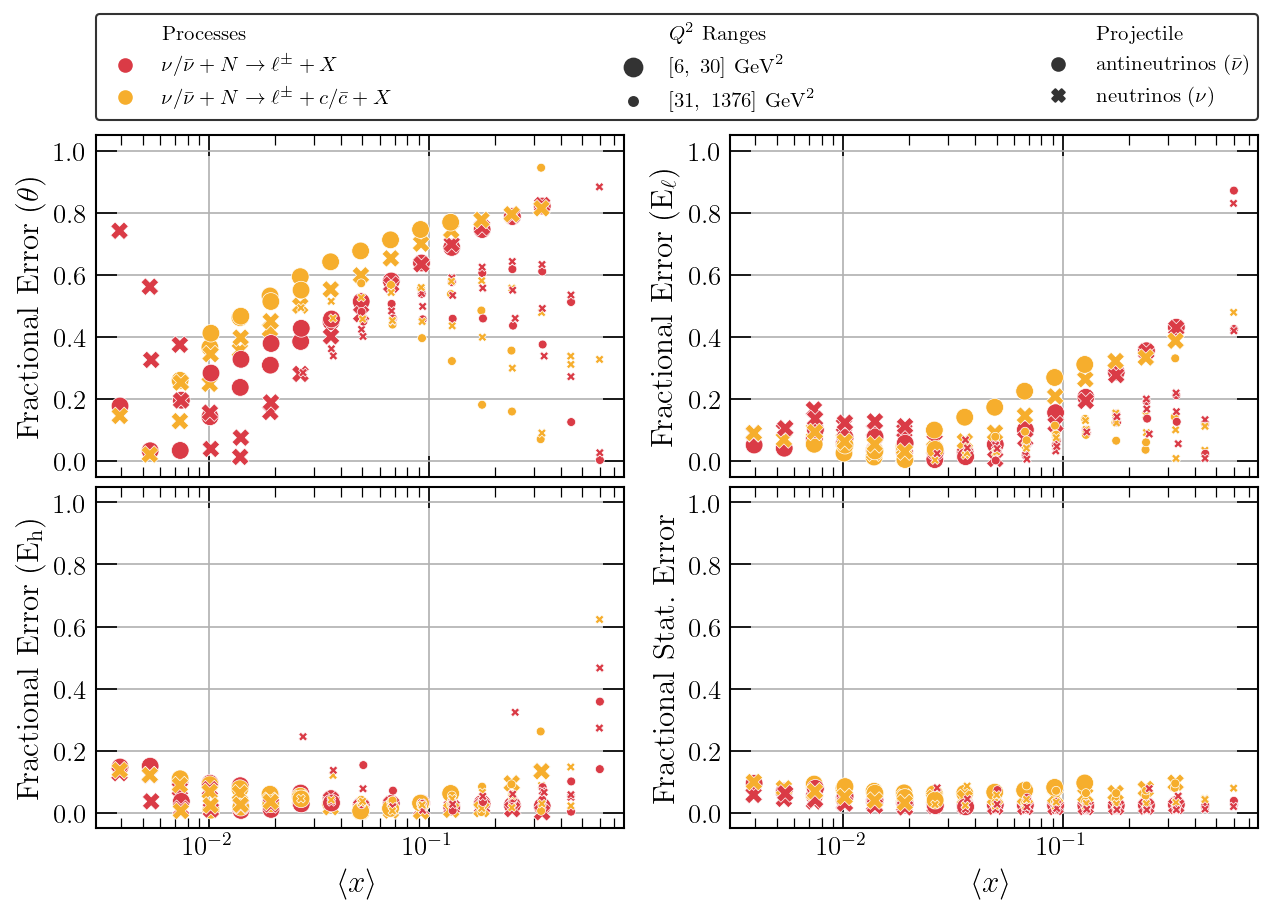

In [67]:
plot_percentage_error(predictions)